# 🏥 Patient Deterioration Risk Prediction
## Team member 
  Belal Edoor
  Mohammad Alhoor
## Project Overview
This project focuses on predicting the risk of patient deterioration in hospital settings using machine learning.  
By analyzing vital signs and laboratory measurements, the model classifies patients into either **deterioration** or **no deterioration**, enabling early clinical intervention and improving patient safety and outcomes.  

In clinical settings, the ability to predict a patient's physiological decline before it becomes critical is life-saving.  
This project builds a predictive analytics system that monitors **hourly patient data** to forecast potential deterioration within a **12-hour window**.  

The primary objective is **False Negative (FN) Reduction**, ensuring that no high-risk patient is overlooked by the system, even if it leads to a slightly higher rate of false alarms (False Positives).

---

## Dataset
The model utilizes a **Panel Data** format (longitudinal data), where each row represents one hour of a patient’s stay.

- **File Name:** `hospital_deterioration_hourly_panel.csv`  
- **Total Records:** 2,000 hourly observations  

### Key Feature Categories
- **Vital Signs:** `heart_rate`, `respiratory_rate`, `spo2_pct`, `temperature_c`, `systolic_bp`, `diastolic_bp`  
- **Laboratory Results:** `wbc_count`, `lactate`, `creatinine`, `crp_level`, `hemoglobin`  
- **Clinical Intervention:** `oxygen_flow`, `oxygen_device`, `nurse_alert`, `mobility_score`  
- **Demographics:** `age`, `gender`, `comorbidity_index`  
- **Target Variable:** `deterioration_next_12h` (Binary: 1 if deterioration occurs in the next 12 hours, 0 otherwise)  

> The label is generated using a rule-based clinical deterioration function.

---

## Data Preprocessing & Engineering
Before feeding the data into models, several steps were taken to ensure data integrity:

1. **Imputation:** Pipeline includes `SimpleImputer` (mean strategy) to handle any future missing medical values.  
2. **Encoding:** Categorical variables such as `gender`, `admission_type`, and `oxygen_device` were converted into numerical format using One-Hot Encoding.  
3. **Class Imbalance Handling:** "Deterioration" events are rarer than "Stable" states. Class Weights are calculated to penalize the model more heavily when missing a positive case.

---

## Modeling Strategies

### Strategy A: Multi-Layer Perceptron (Neural Network)
- Captures complex non-linear relationships among patients’ vital signs and clinical measurements.  
- **Architecture:** Input layer → one or more hidden layers (64 neurons, ReLU) → Sigmoid output layer  
- **Optimization:** Adam optimizer for efficient convergence  
- **Medical Objective:** Maximize **Recall** to detect deteriorating patients early and minimize False Negatives  

### Strategy B: Random Forest (Ensemble Learning)
- Robust and interpretable alternative, handles noisy and heterogeneous medical data.  
- **Configuration:** Ensemble of 300 decision trees (`n_estimators=300`)  
- **Class Imbalance Handling:** `class_weight='balanced'` or `balanced_subsample`  
- **Advantage:** Provides feature importance to identify most influential predictors (e.g., lactate levels, heart rate)  

---

## Summary
- Neural Network: Captures complex patterns, maximizes Recall.  
- Random Forest: Robust, interpretable, identifies critical features.  
- Together: Provide a balanced, reliable framework for patient deterioration prediction.

---

## Performance Evaluation (Medical Context)
Accuracy is **misleading** for imbalanced datasets.  
Evaluation focuses on **clinically meaningful metrics**:

### Key Metrics
- **Recall (Sensitivity):** Proportion of actual deterioration cases correctly identified.  
  - High Recall → High patient safety  
- **Confusion Matrix Analysis:**  
  - **True Positives (TP):** Correctly detected deterioration  
  - **False Negatives (FN):** Missed deteriorating patients (most critical error)  
- **F1-Score:** Balances Recall and Precision to avoid excessive false alarms (False Positives)

---

## Prediction
- New patient data can be fed into the model as a dictionary of feature values.  
- Data is preprocessed similarly to training data (scaling, encoding).  
- Model predicts probabilities of deterioration; the highest probability determines the predicted class.  
- Predicted categories are labeled as **Deterioration** or **No Deterioration**.

---

## Conclusion
- Machine learning models can effectively predict patient deterioration using vital signs and clinical data.  
- Emphasis on **maximizing Recall** and **minimizing False Negatives** ensures patient safety.  
- Neural Network captures non-linear patterns, Random Forest provides interpretability.  
- Threshold tuning and confusion matrix analysis help reduce missed critical cases while keeping the system clinically usable.  
- Overall, this project demonstrates the potential of ML for early clinical intervention and safer healthcare decision-making.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight


# Data Loading and Cleaning
# In this cell, we read the CSV file containing the hourly patient data.
# After loading, we drop any rows with missing target values (y) because they cannot be used for training.
# Then, we separate the independent variables X and the target variable y.


In [2]:
df = pd.read_csv("hospital_deterioration_hourly_panel.csv")

df = df.dropna(subset=[df.columns[-1]])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


# Categorical Encoding and Missing Value Imputation
# We convert all categorical variables into dummy variables (0 or 1) for use in the neural network.
# Any text value 'none' is replaced with NaN.
# Then, we use SimpleImputer to fill missing values with the mean of each column.
# This ensures all data is numeric and ready for the model.


In [3]:
X = pd.get_dummies(X, drop_first=True)
X.replace('none', np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


# Train-Test Split and Class Weights
# We split the dataset into 80% training and 20% testing, using stratify to preserve class proportions.
# Calculating class weights balances the influence of rare classes (patient deterioration) during training,
# which helps reduce errors on the critical class.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [5]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(0.5285733711549834), 1: np.float64(9.249405124232196)}


# Building the Neural Network Model
# The model consists of:
# - One hidden layer (64 neurons) with ReLU activation to learn non-linear relationships.
# - One output layer with Sigmoid activation to predict the probability of deterioration (0 or 1).
# Binary Crossentropy loss is used because this is a binary classification problem.
# Recall is chosen as the metric because it is critical in medical settings (to avoid missing deteriorating patients).

	​


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training the Model with EarlyStopping
# We use EarlyStopping to monitor the best val_Recall on validation data.
# If val_Recall does not improve for 'patience' number of epochs, training stops automatically.
# class_weight is passed to reduce the impact of imbalanced classes.
# validation_split=0.2 ensures a portion of the training data is used for validation.


In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_Recall',
    mode='max',
    patience=20,
    min_delta=0.001,
    restore_best_weights=True
)


model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    class_weight=class_weight_dict,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - Recall: 0.7807 - loss: 6.9012 - val_Recall: 0.9848 - val_loss: 5.1674
Epoch 2/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.8636 - loss: 2.2985 - val_Recall: 0.9528 - val_loss: 1.8525
Epoch 3/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.8942 - loss: 1.4820 - val_Recall: 0.9351 - val_loss: 0.5310
Epoch 4/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.9202 - loss: 1.0998 - val_Recall: 0.9989 - val_loss: 3.1069
Epoch 5/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.9339 - loss: 0.9216 - val_Recall: 0.9528 - val_loss: 0.1844
Epoch 6/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.9459 - loss: 0.6107 - val_Recall: 0.9992 - val_loss: 0.7053
Epoch 7/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - Recall: 0.9472 - loss: 0.5839 - val_Recall: 0.9978 - val_loss: 0.7775
Epoch 8/1000
8358/8358 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - Recall: 0.9556 - loss: 0.3508 - val_Re

# Making Predictions and Confusion Matrix
# We predict probabilities on the test set using model.predict.
# Probabilities are converted into binary predictions using a custom threshold (e.g., 0.35) to increase Recall.
# Confusion matrix is calculated and visualized using a heatmap.
# We also extract True Positives (TP) and False Negatives (FN), which are critical metrics for patient deterioration.


In [66]:
THRESHOLD = 0.35

y_probs_nn = model.predict(X_test).flatten()
y_pred_nn = (y_probs_nn >= THRESHOLD).astype(int)


2612/2612 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


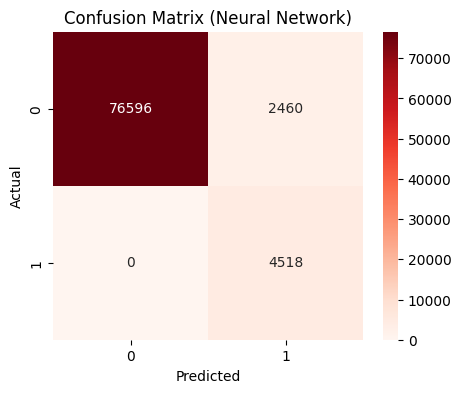

Neural Network False Negatives: 0
Neural Network True Positives: 4518


In [67]:


cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Neural Network)')
plt.show()

TN_nn, FP_nn, FN_nn, TP_nn = cm_nn.ravel()
print('Neural Network False Negatives:', FN_nn)
print('Neural Network True Positives:', TP_nn)


In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
accuracy_nn = accuracy_score(y_test, y_pred_nn)

print("\nNeural Network Metrics:")
print(f"Precision: {precision_nn:.3f}")
print(f"Recall: {recall_nn:.3f}")
print(f"F1 Score: {f1_nn:.3f}")
print(f"Accuracy: {accuracy_nn:.3f}")



Neural Network Metrics:
Precision: 0.647
Recall: 1.000
F1 Score: 0.786
Accuracy: 0.971


In [63]:
from sklearn.metrics import accuracy_score

# Accuracy Neural Network
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy: {accuracy_nn:.3f}")

Neural Network Accuracy: 0.971


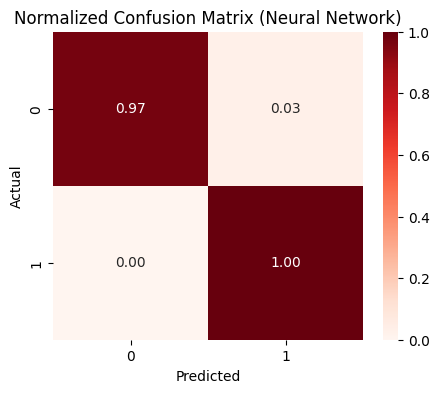

In [64]:
import numpy as np

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix (Neural Network)')
plt.show()


In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: np.float64(0.5285733711549834),
                                     1: np.float64(9.249405124232196)},
                       n_estimators=300, n_jobs=-1, random_state=42)

In [40]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9929403881589968


In [69]:
THRESHOLD = 0.35
y_probs_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_probs_rf >= THRESHOLD).astype(int)


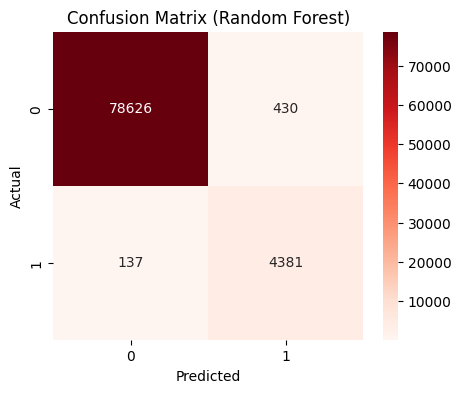

Random Forest False Negatives: 137
Random Forest True Positives: 4381


In [70]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()
print('Random Forest False Negatives:', FN_rf)
print('Random Forest True Positives:', TP_rf)


In [71]:
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\nRandom Forest Metrics:")
print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"F1 Score: {f1_rf:.3f}")
print(f"Accuracy: {accuracy_rf:.3f}")



Random Forest Metrics:
Precision: 0.911
Recall: 0.970
F1 Score: 0.939
Accuracy: 0.993


In [72]:
metrics_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest'],
    'Recall': [recall_nn, recall_rf],
    'Precision': [precision_nn, precision_rf],
    'F1-Score': [f1_nn, f1_rf],
    'Accuracy': [accuracy_nn, accuracy_rf]
})

print("\nComparison Table:")
print(metrics_df)



Comparison Table:
            Model    Recall  Precision  F1-Score  Accuracy
0  Neural Network  1.000000   0.647463  0.786013  0.970565
1   Random Forest  0.969677   0.910621  0.939222  0.993216
